In [1]:
import json
import os
import re
from cgi import print_arguments

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [3]:
def get_prediction(model, eval_data, step = 10):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step]).to(device)
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
    
    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels

def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score

In [5]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-12 14:31:44--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-12 14:31:45--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  6.51MB/s 

In [6]:
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

In [63]:
train_data = FashionMNIST(".", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_data = FashionMNIST(".", train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = 256,
    shuffle = True,
    num_workers = 6
)

test_data_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = 256,
    shuffle = False,
    num_workers = 6
)

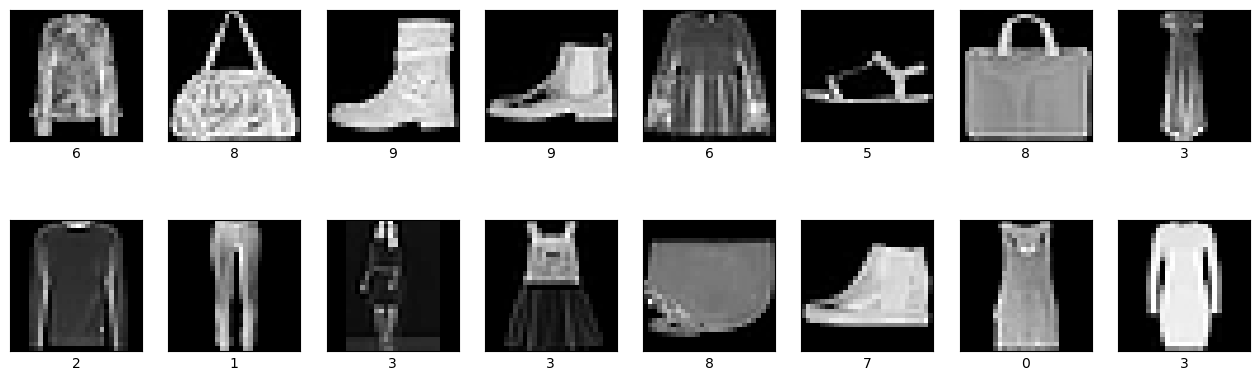

In [64]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_data))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_data[random_index][0].squeeze(0).numpy().reshape([28, 28]), cmap = 'gray')
        ax.set_xlabel(train_data[random_index][1])
plt.show()

Text(0.5, 1.0, 'Image label: 8')

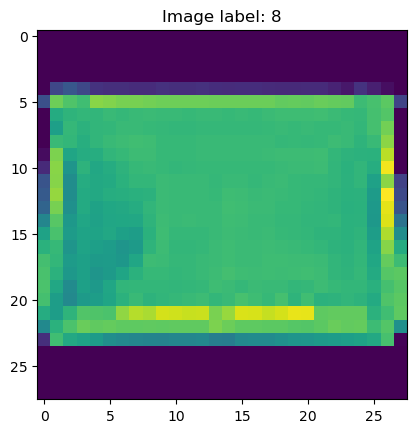

In [65]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")

In [66]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [76]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( # 28x28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5), # 24x24
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2), # 12x12
            #nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5) # 8x8
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=6 * 12 * 12, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=10)
        )
    
    def forward(self, image):
        out = self.encoder(image)
        out = out.view(out.size(0), -1)
        return self.head(out)

In [81]:
model_task_1 = Model().to(device)
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [82]:
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")

Everything seems fine!


In [83]:
from tqdm.notebook import tqdm

NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    for batch in tqdm(train_data_loader):
        image = batch[0].to(device)
        label = batch[1].to(device)
        
        optimizer.zero_grad()
        y_predicted = model_task_1(image)
        loss = criterion(y_predicted, label)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

In [84]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.95833


In [85]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9046


In [86]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
        train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

In [89]:
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_prediction(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"]).to(device)
    ),
    "test_predictions_task_1": get_prediction(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"]).to(device)
    ),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")

File saved to `submission_dict_fmnist_task_1.json`
